In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nodes.nodes import FoldiakNode, InputNode
from nodes.net import FoldiakShapedNet
from nodes.layer import ShapedLayer

import random
random.seed(7)

#Builds layers and assembles into a network

inputlayer = ShapedLayer((8,8))
foldiaklayer = ShapedLayer(32)

foldiaklayer.fillnodes(FoldiakNode)
inputlayer.fillnodes(InputNode)

network = FoldiakShapedNet()
network.append(inputlayer)
network.append(foldiaklayer)
network.connect_foldiak(inputlayer, foldiaklayer)

#Integration parameters

network.setparam("intmethod","LSODA")
network.setparam("l",10)
network.setparam("tmax",100)

#Setup network

network.setup()

#Load and shuffle data
samples = np.loadtxt("../data/lines_balanced.csv")
keys = np.loadtxt("../data/keys_balanced.csv")

perm = np.random.permutation(len(keys))

samples = samples[perm]
keys = keys[perm]

#Set network parameters

network.setparam("a",0.1)
network.setparam("b",0.02)
network.setparam("y",0.02)
network.setparam("d",0.02)

#Create vectors for use in assigning each output to a line; needed to measure error.

possibletypes = []
for i in range(8):
    sample = np.zeros((8,8))
    sample[i,:] = 1
    possibletypes.append(sample)
for i in range(8):
    sample = np.zeros((8,8))
    sample[:,i] = 1
    possibletypes.append(sample)
    
errors = []

startnum = 0

samples_per_bin = 20
number_of_bins = 200

#samples_per_bin = 1
#number_of_bins = 1

#ps = []
#ts = []
ws = []
qs = []


for startnum in range(number_of_bins):
    #test_keys_this = keys[startnum*samples_per_bin:startnum*samples_per_bin+samples_per_bin, :]
    test_samples_this = samples[startnum*samples_per_bin:startnum*samples_per_bin+samples_per_bin]
    
    #Train for samples_per_bin samples
    for i in range(samples_per_bin):
        inputlayer.setvals(test_samples_this[i,:])
        network.update()

    #Calculate error
    esum = 0
    recon = np.empty_like(network.cgroups[0].getbiases()[:,0])
    for j in range(32):
        mem = network.cgroups[0].getbiases()[:,j]
        recon += mem*foldiaklayer.returnvals()[j]
    
    errors.append(np.sum(np.abs(recon - test_samples_this[-1,:])))
    
    ws.append(network.cgroups[1].getbiases())
    qs.append(network.cgroups[0].getbiases())

    #ts.append(foldiaklayer.returnthres())
    #ps.append([i.p for i in foldiaklayer.nodes])
    
    if ((startnum+1)%100)==0:
        print("Finished: " + str((startnum+1)*samples_per_bin))



Finished: 2000
Finished: 4000


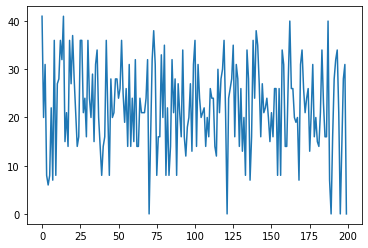

In [2]:
plt.plot(errors)
plt.show()

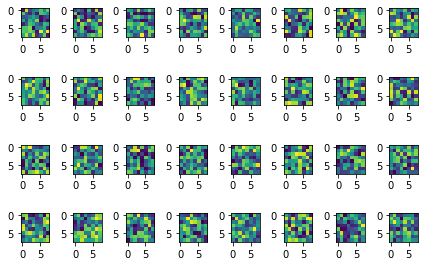

In [3]:
fig=plt.figure()

for node_num in range(len(foldiaklayer.nodes)):
    testbias = []
    connects = np.reshape(network.cgroups[0].npconnects, -1)
    for node in inputlayer.nodes:
        for i in connects:
            if (i.input is node) and (i.output is foldiaklayer.nodes[node_num]):
                testbias.append(i.bias)
    fig.add_subplot(4,8,node_num+1)
            
    im = plt.imshow(np.array(testbias).reshape((8,8)))
fig.tight_layout()
plt.show()

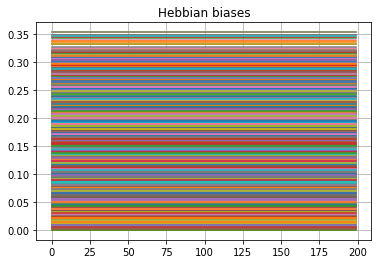

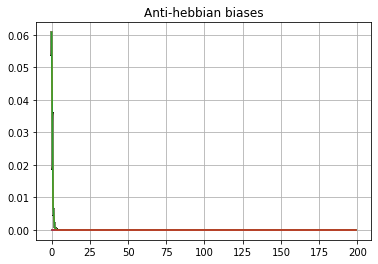

In [4]:
#plt.plot(ts)
#plt.grid()
#plt.title("Threshold values")
#plt.show()
#plt.plot([i*1000 for i in range(len(ts))], ps)
#plt.xlabel("Samples")
#plt.ylabel("p")
#plt.grid()
#plt.title("Bit Probabilities")
#plt.show()
for n in range(32):
    plt.plot([i[:,n] for i in qs])
plt.grid()
plt.title("Hebbian biases")
plt.show()
for n in range(32):
    plt.plot([i[:,n] for i in ws])
plt.grid()
plt.title("Anti-hebbian biases")
plt.show()

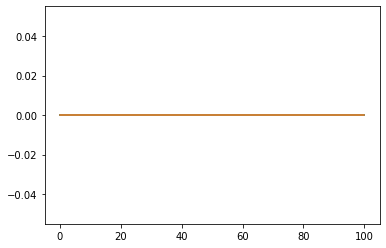

In [5]:
ytplot = network.diffeqs[0].getytplot()
for i in range(32):
    plt.plot(ytplot[1],ytplot[0][i])
plt.show()

In [6]:
foldiaklayer.returnvals()

array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0.])